# Compatibility analysis

The notebook contains the comprhensive analysis and results from the optimization of RB fidelity of D1 qubit.
The method considered are nelder-mead, SLSQP, genetics algorithms (`cma` library)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


In [3]:
methods = ['nelder-mead','SLSQP','cma']
directories = [f"D1_{method}_post_ft_true" for method in methods]

In [4]:
data_dict = {}

for directory in directories:
    file_path = f"{directory}/optimization_history.npz"
    loaded = np.load(file_path)

    # Store the values in a nested dictionary structure
    data_dict[directory] = {
        'iterations': loaded['iterations'],
        'parameters': loaded['parameters'],
        'objective_values': loaded['objective_values'],
        'objective_values_error': loaded['objective_value_errors']
    }

In [5]:
global_min = None
global_max = None

for directory in directories:
    objective_values = data_dict[directory]['objective_values']
    scaled_values = 1 - objective_values
    
    if global_min is None or global_max is None:
        global_min = np.min(scaled_values)
        global_max = np.max(scaled_values)
    else:
        global_min = min(global_min, np.min(scaled_values))
        global_max = max(global_max, np.max(scaled_values))

print(global_min)
print(global_max)

0.7877149669104944
0.9973061761479415


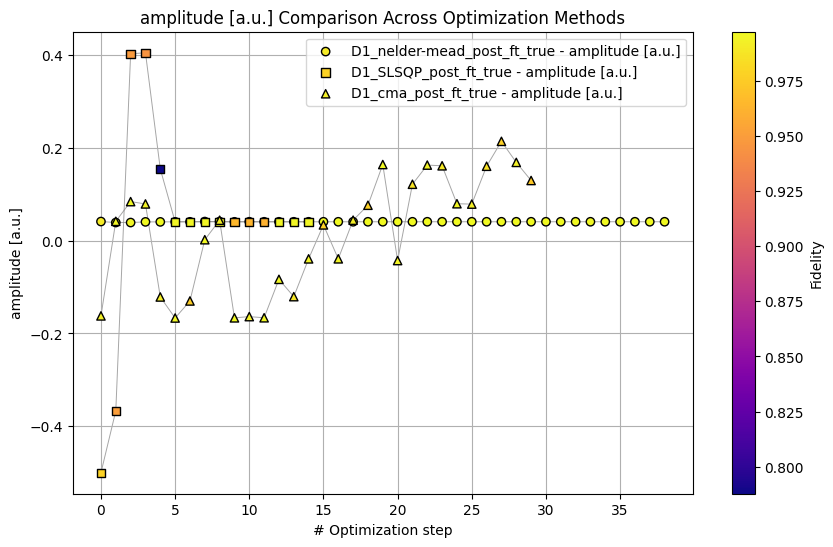

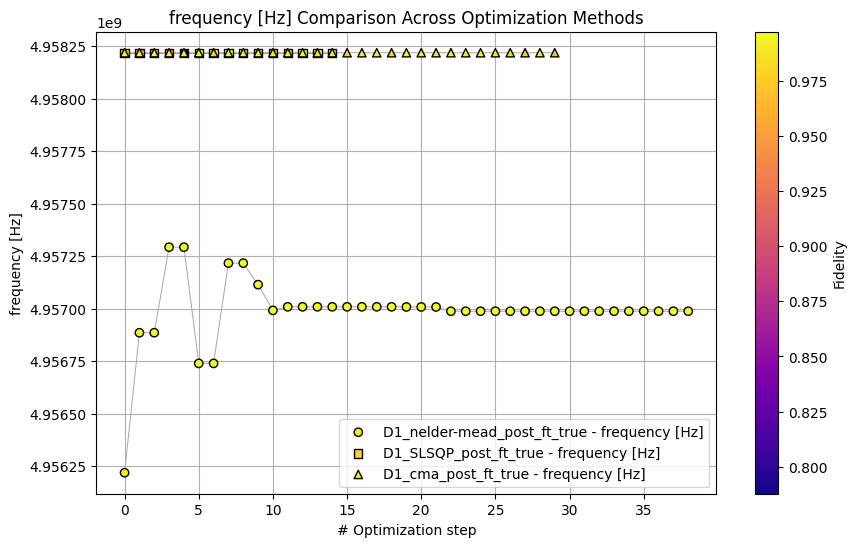

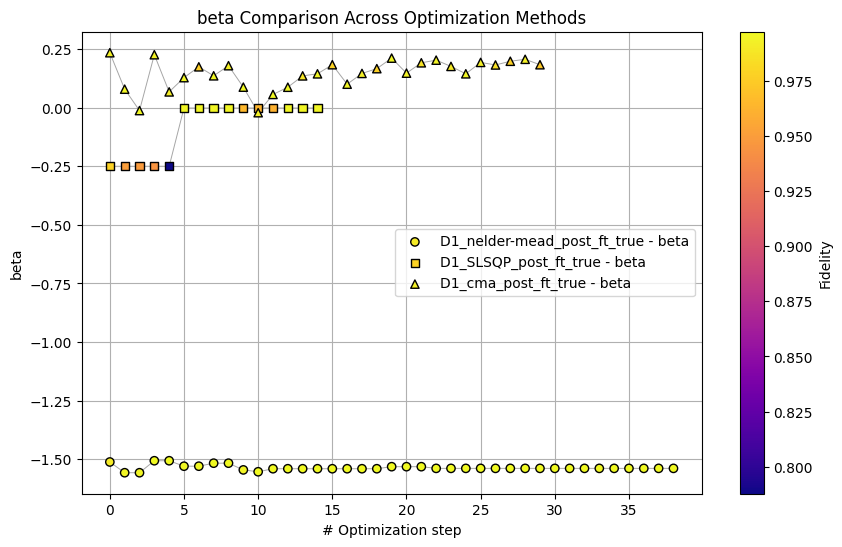

In [6]:
params_name = ['amplitude [a.u.]', 'frequency [Hz]', 'beta']
marker_styles = ['o', 's', '^']

for i, param in enumerate(params_name):
    plt.figure(figsize=(10, 6))  
    
    for j, directory in enumerate(directories):
        iterations = data_dict[directory]['iterations']
        parameter_values = data_dict[directory]['parameters'][:, i]
        objective_values = data_dict[directory]['objective_values']

        # Plot the line without markers
        plt.plot(iterations, parameter_values, color='gray', linewidth=0.7, alpha=0.7, zorder=1)

        # Use scatter plot to add markers with colormap
        sc = plt.scatter(
            iterations, parameter_values, 
            c=1 - objective_values, cmap='plasma', 
            edgecolor='k', marker=marker_styles[j], zorder=2,
            vmin=global_min, vmax=global_max, 
            label=f'{directory} - {param}'
        )
    
    plt.xlabel('# Optimization step')
    plt.ylabel(param)
    plt.title(f'{param} Comparison Across Optimization Methods')
    plt.legend()
    plt.grid()

    plt.colorbar(sc, label='Fidelity')

    plt.show()

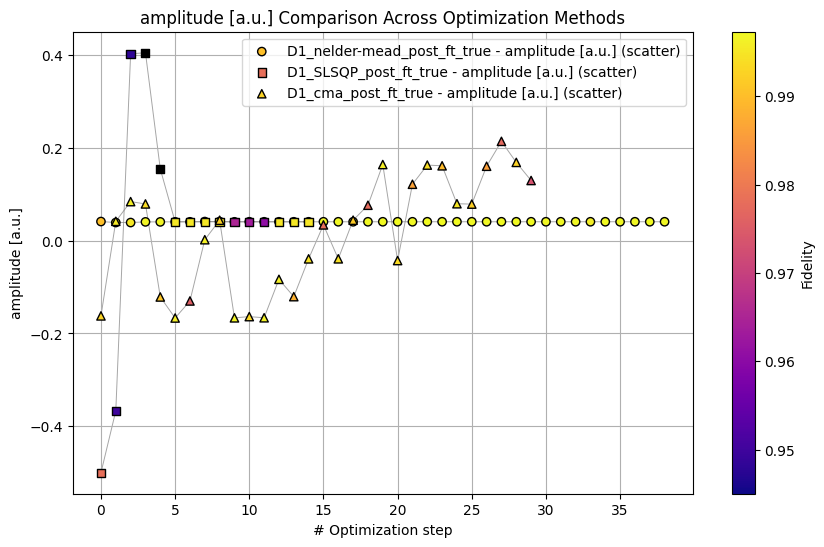

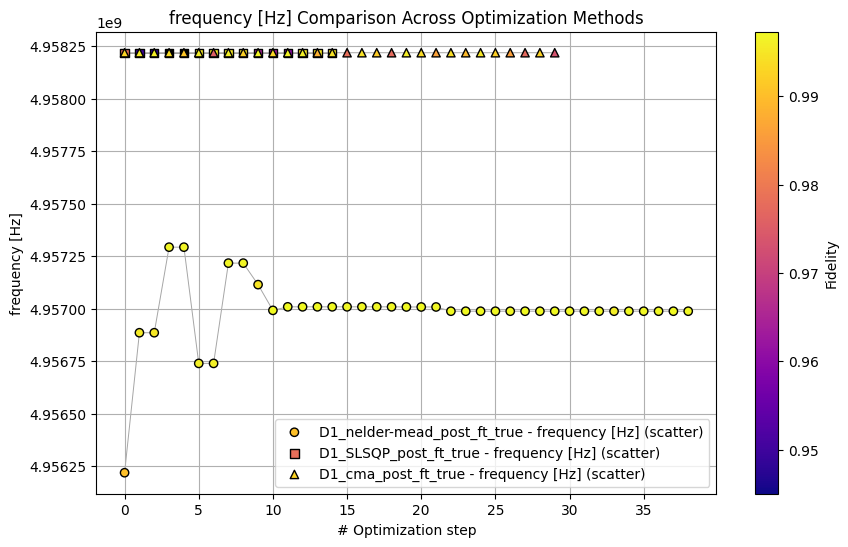

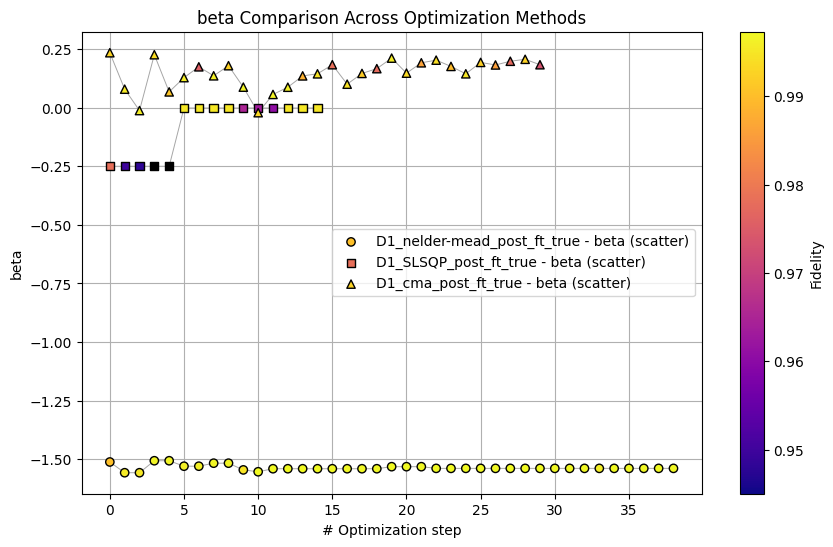

In [8]:
global_min = 0.945


for i, param in enumerate(params_name):
    plt.figure(figsize=(10, 6))  
    
    for j, directory in enumerate(directories):
        iterations = data_dict[directory]['iterations']
        parameter_values = data_dict[directory]['parameters'][:, i]
        objective_values = data_dict[directory]['objective_values']
        scaled_values = 1 - objective_values

        # Plot the line 
        plt.plot(iterations, parameter_values, color='gray', linewidth=0.7, alpha=0.7, zorder=1)
        
        # Create masks for color conditions
        threshold_mask = scaled_values >= global_min
        color_values = np.where(threshold_mask, scaled_values, np.nan)  # NaN for values below threshold

        # Scatter plot for points meeting threshold condition
        sc = plt.scatter(
            iterations[threshold_mask], parameter_values[threshold_mask], 
            c=color_values[threshold_mask], cmap='plasma', 
            edgecolor='k', marker=marker_styles[j], zorder=2,
            vmin=global_min, vmax=global_max, 
            label=f'{directory} - {param} (scatter)'
        )

        # Scatter plot for points below the threshold (black points)
        plt.scatter(
            iterations[~threshold_mask], parameter_values[~threshold_mask], 
            c='black', edgecolor='k', marker=marker_styles[j], zorder=2
        )
    
    plt.xlabel('# Optimization step')
    plt.ylabel(param)
    plt.title(f'{param} Comparison Across Optimization Methods')
    plt.legend()
    plt.grid()

    plt.colorbar(sc, label='Fidelity')

    plt.show()


In [ ]:
fig = go.Figure()

for j, directory in enumerate(directories):
    parameter_values = data_dict[directory]['parameters']
    objective_values = data_dict[directory]['objective_values']
    
    x_values = parameter_values[:, 0]  # Amplitude
    y_values = parameter_values[:, 1]  # Frequency
    z_values = parameter_values[:, 2]  # Beta
    
    marker_symbols = ['circle', 'square', 'cross']
    marker_symbol = marker_symbols[j % len(marker_symbols)]  # Cycle through available symbols
    
    fig.add_trace(go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='markers',
        marker=dict(
            size=8,
            symbol=marker_symbol,
            color=1 - objective_values,
            colorscale='Plasma',
            cmin=global_min,
            cmax=global_max,
            colorbar=dict(title='1 - Objective Value'),
            line=dict(width=1, color='black'),
        ),
        name=directory,
    ))

fig.update_layout(
    title='3D Parameter Comparison Across Optimization Methods',
    scene=dict(
        xaxis_title=params_name[0],
        yaxis_title=params_name[1],
        zaxis_title=params_name[2],
        xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        zaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    ),
    width=1200,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

# Show the figure
fig.show()